In [3]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorboard.plugins import projector
import sys
from PIL import Image

import smfret.fit as fit
import smfret.finetuning as finetuning

from smfret.tf_layers import Attention
from smfret.tf_layers import Conv
from smfret.tf_layers import Summary
from smfret.tf_layers import PrependTaskToken
from smfret.tf_layers import Embedding
from smfret.tf_layers import PositionEmbedding

from smfret.trace_simulator import Simulator
from smfret.trace_simulator import ParameterGenerator
from smfret.trace_simulator import SimulatedTraceSet

from smfret.multi_task_learning import FRETStateTraceSet
from smfret.multi_task_learning import MultistepPhotobleachingTraceSet
from smfret.multi_task_learning import NoiseLevelTraceSet
from smfret.dataset import MatlabTraceSet
from smfret.dataset import FRETTrace
from smfret.dataset import FRETTraceSet

from smfret.multi_task_learning import SavedTraceSet

from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from enum import Enum
import json
import umap
import scipy

from sciplotlib import style as spstyle
from tqdm.auto import tqdm

In [4]:
encoder = keras.models.load_model('../saved_models/best_model/encoder-20240511-131505.h5', compile=False)

In [5]:
def convert_single_channel_data_to_dataset(file, label=None, start_frame=0, max_frames=8000):
    """Converts .MAT data into a model-compatible tensor."""
    key = 'traces'
    conv_width = 100
    dialation_factor = 1
    multistep_data = scipy.io.loadmat(file)[key][:, ::dialation_factor]

    n, length = np.shape(multistep_data)
    padding_length = conv_width - length % conv_width

    multistep_data = multistep_data

    padding = np.repeat(multistep_data[:, -2:-1], padding_length, axis=-1)
    multistep_data = np.concatenate([multistep_data, padding], axis=-1)
    time = (1 + np.arange(length + padding_length))
    
    trace_set = FRETTraceSet()
    trace_set.donor = np.zeros_like(multistep_data)
    trace_set.acceptor = multistep_data
    trace_set.time = time
    trace_set.size = n
    if label is None:
        trace_set.label = np.zeros_like(multistep_data)
    else:
        trace_set.label = np.zeros_like(multistep_data) + label
    trace_set.broadcast_data_to_traces()
    # ad-hoc trim
    trace_set.trim(start_frame=start_frame, n_frame=max_frames)

    return trace_set

In [7]:
files = '''
../saved_dataset/downstream/simreps/50 fM MUT n1.tif_whole_traces.mat
../saved_dataset/downstream/simreps/50 fM MUT n2.tif_whole_traces.mat
../saved_dataset/downstream/simreps/50 fM MUT n3.tif_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_NDC-1_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_NDC-2_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_NDC-3_whole_traces.mat
../saved_dataset/downstream/simreps/NDC n1_whole_traces.mat
../saved_dataset/downstream/simreps/NDC n2_whole_traces.mat
../saved_dataset/downstream/simreps/NDC n3_whole_traces.mat
../saved_dataset/downstream/simreps/50 nM WT n1.tif_whole_traces.mat
../saved_dataset/downstream/simreps/50 nM WT n2.tif_whole_traces.mat
../saved_dataset/downstream/simreps/50 nM WT n3.tif_whole_traces.mat
../saved_dataset/downstream/simreps/50 nM WT n4.tif_whole_traces.mat
../saved_dataset/downstream/simreps/50 nM WT n7.tif_whole_traces.mat
'''.strip().split('\n')
    
trace_sets = []
embedding_list = []
label_list = []
for file in files:
    if 'MUT' in file:
        label = 1
    else:
        label = 0
    trace_set = convert_single_channel_data_to_dataset(file, label, max_frames=1000)
    embedding_list.append(encoder.predict(trace_set.to_tensor()))
    label_list.append(np.max(trace_set.label, axis=-1))

classifier = keras.Sequential([keras.layers.Dense(2)])

classifier.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-2),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

embedding = np.concatenate(embedding_list, axis=0)
label = np.concatenate(label_list, axis=0)

clf = LogisticRegression(multi_class='multinomial', max_iter=50000, tol=1e-8, penalty='l2', class_weight={0: 2E2, 1: 1})
clf.fit(embedding, label)

14/14 [==============================] - 3s 185ms/step


LogisticRegression(class_weight={0: 200.0, 1: 1}, max_iter=50000,
                   multi_class='multinomial', tol=1e-08)

In [8]:
print(f'Embeddings of {embedding.shape[0]} traces generated.')

Embeddings of 3904 traces generated.


WT Maximum Score 0.10396381567384576
WT Negative Positive Cutoff 0.05
% misclassified WT 0.031269543464665414 %


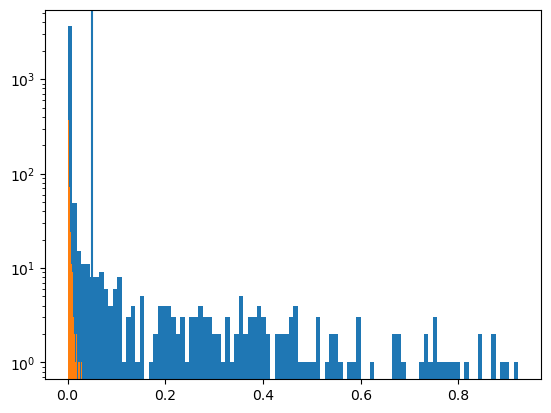

In [12]:
score = clf.predict_proba(embedding)[:, 1]
WT_cutoff = 0.05

print('WT Maximum Score', np.max(score[label == 0]))
print('WT Negative Positive Cutoff', WT_cutoff)
print('% misclassified WT', np.sum(score[label == 0] >= WT_cutoff) / sum(label == 0) * 100, '%')

plt.hist(score, bins=100);
plt.hist(score[label == 0], bins=100);

plt.axvline(WT_cutoff)
plt.yscale('log')

6/6 [==============================] - 1s 147ms/step


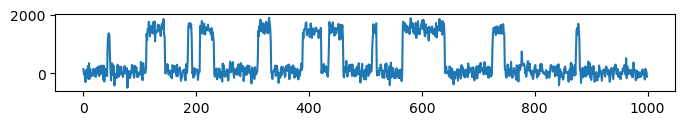

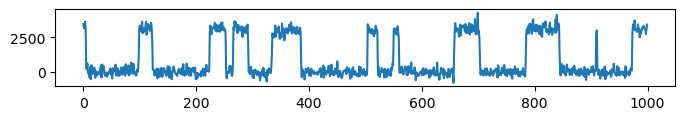

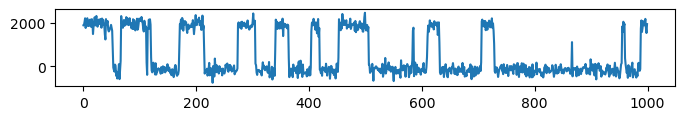

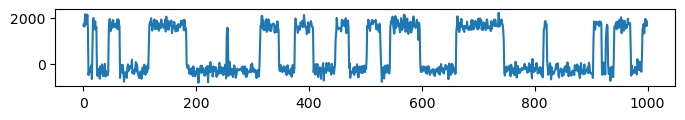

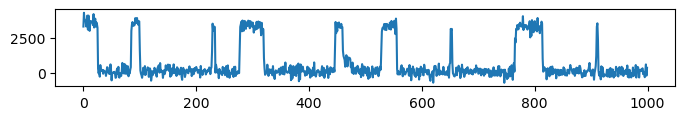

10/10 [==============================] - 1s 137ms/step


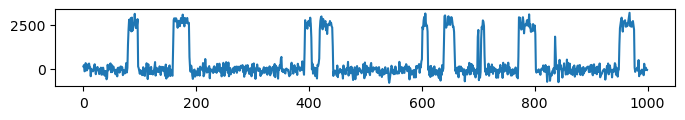

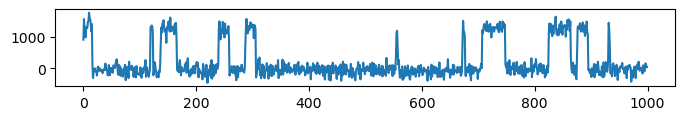

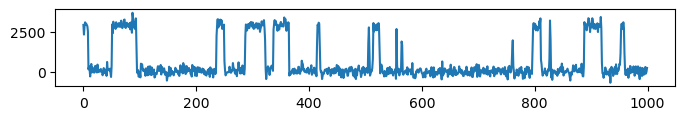

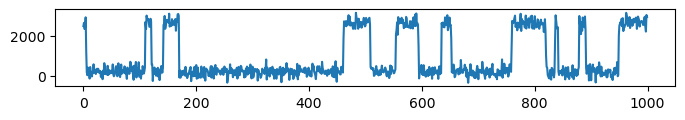

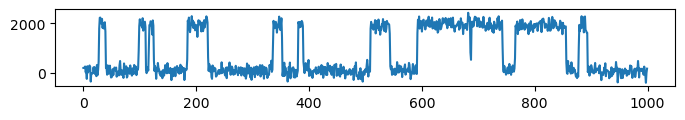

7/7 [==============================] - 1s 136ms/step


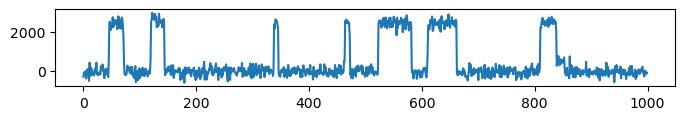

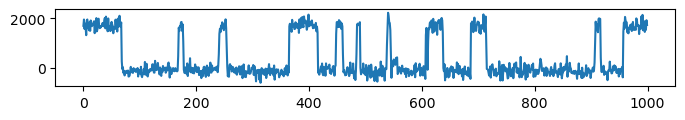

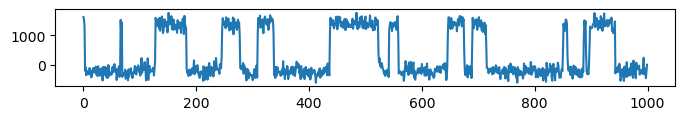

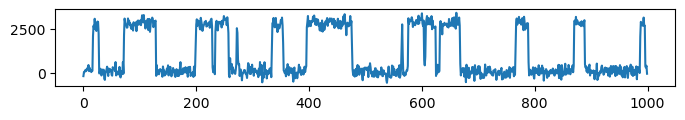

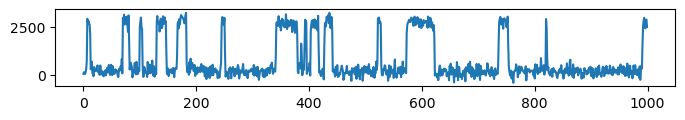

16/16 [==============================] - 3s 178ms/step


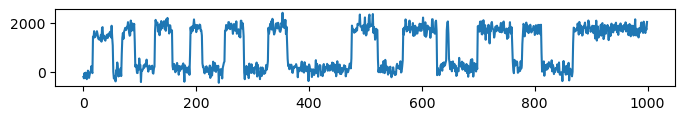

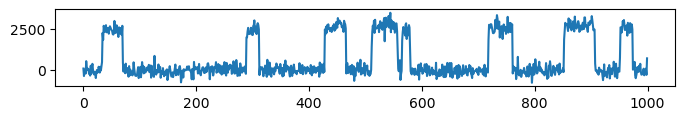

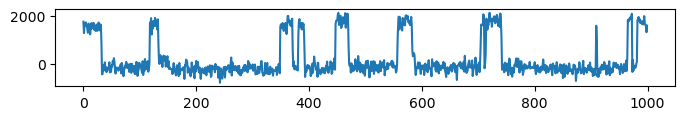

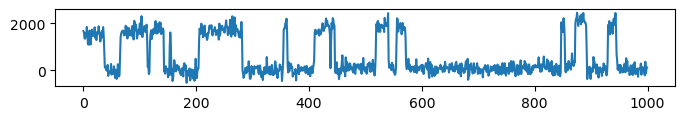

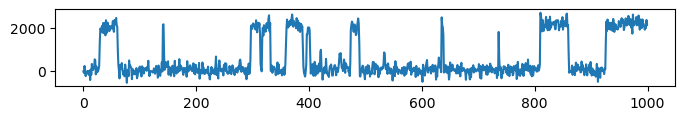

13/13 [==============================] - 2s 130ms/step


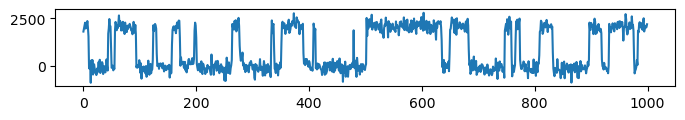

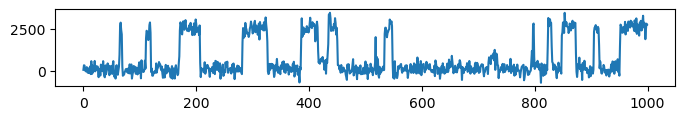

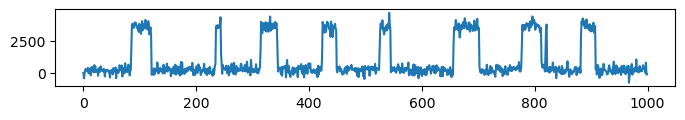

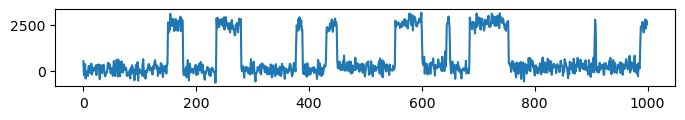

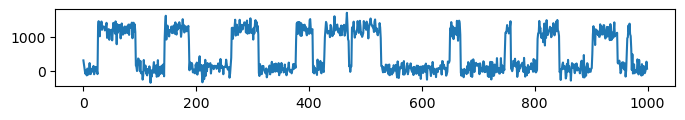

16/16 [==============================] - 3s 168ms/step


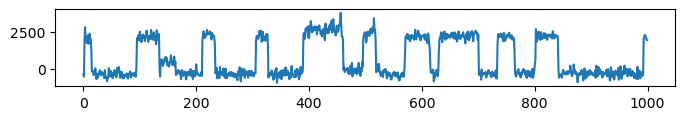

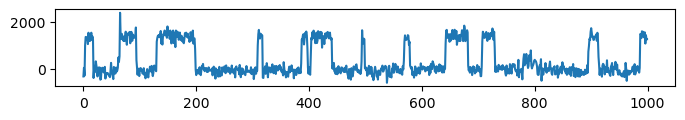

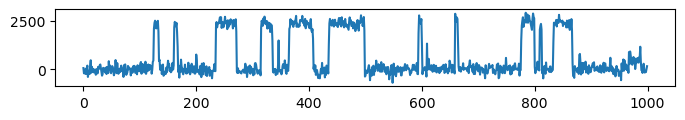

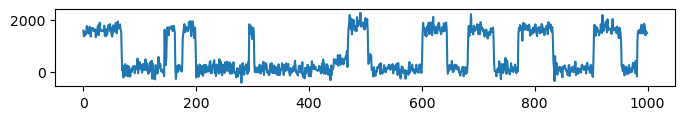

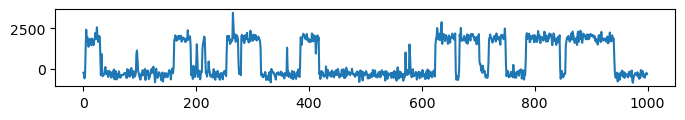

10/10 [==============================] - 1s 137ms/step


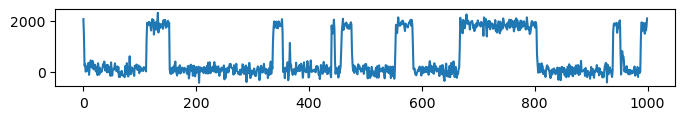

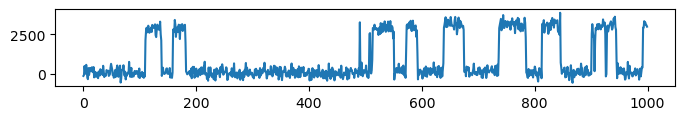

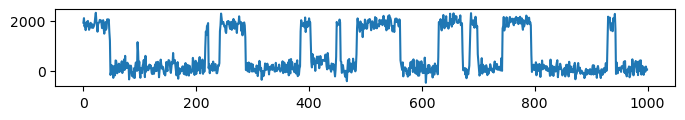

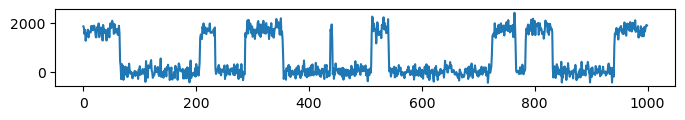

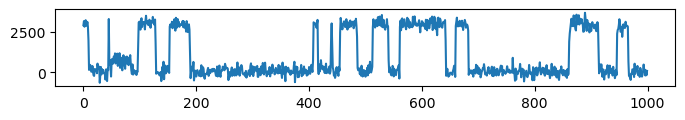

15/15 [==============================] - 2s 128ms/step


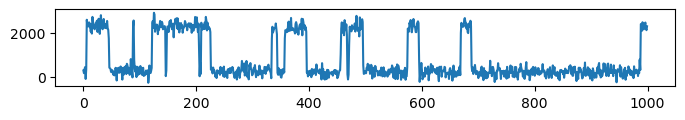

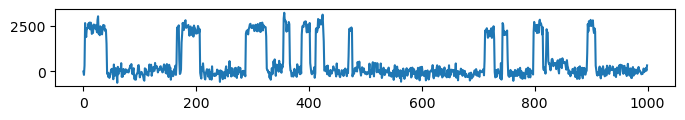

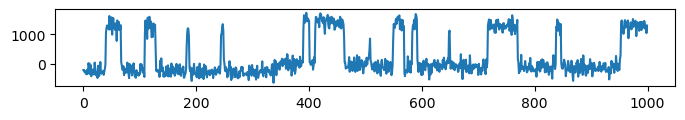

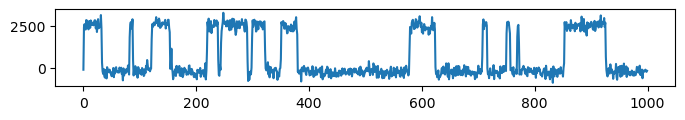

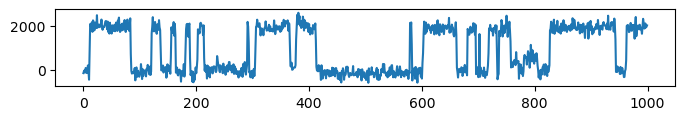

12/12 [==============================] - 2s 131ms/step


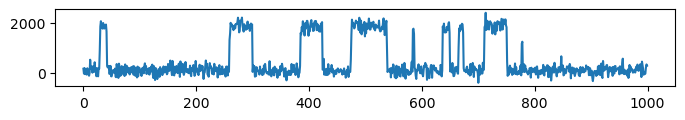

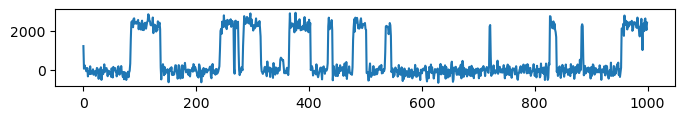

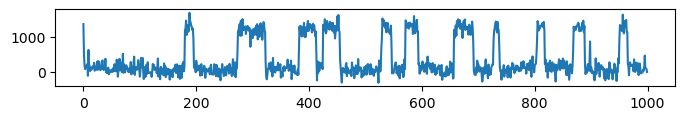

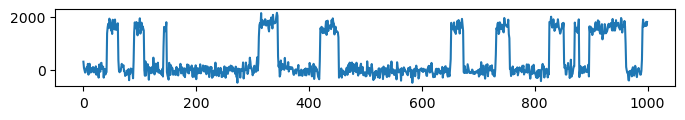

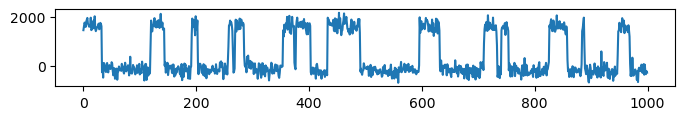

10/10 [==============================] - 1s 132ms/step


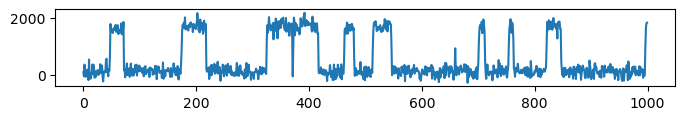

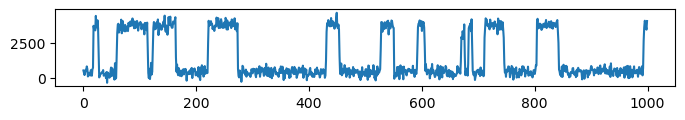

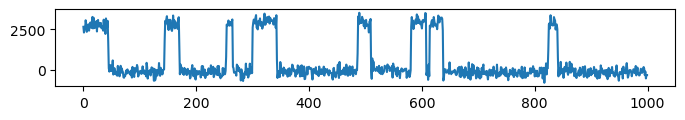

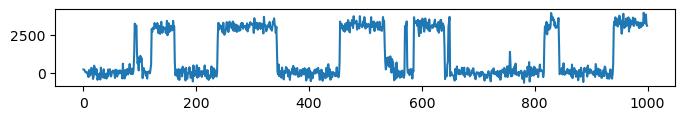

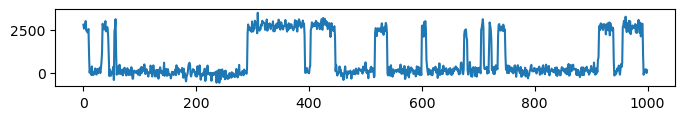

10/10 [==============================] - 2s 215ms/step


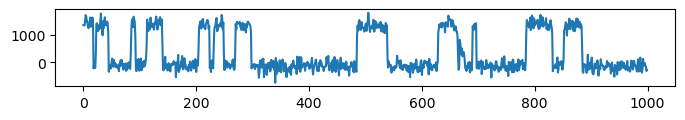

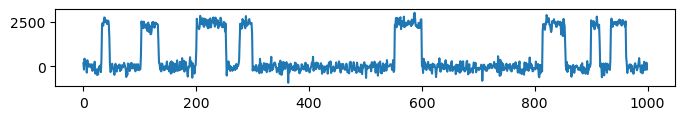

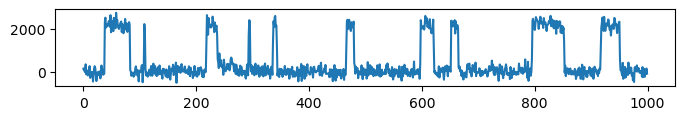

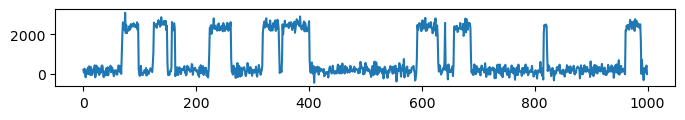

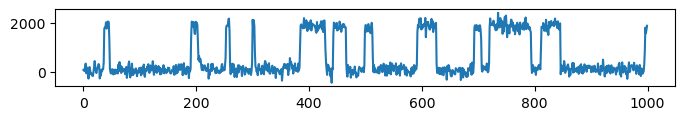

11/11 [==============================] - 2s 136ms/step


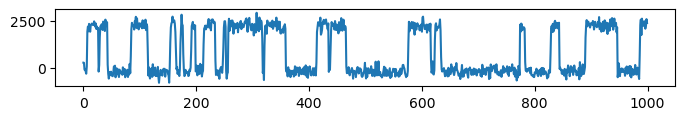

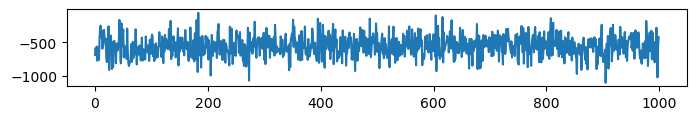

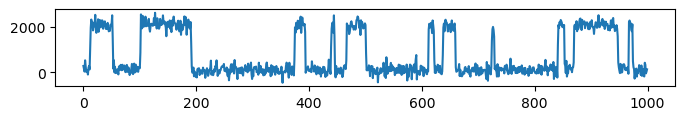

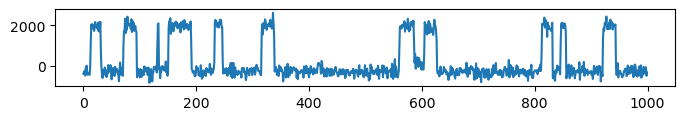

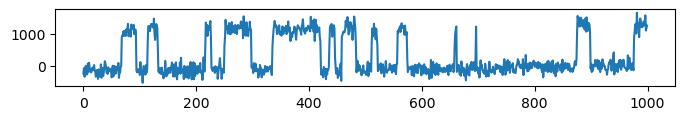

8/8 [==============================] - 2s 269ms/step


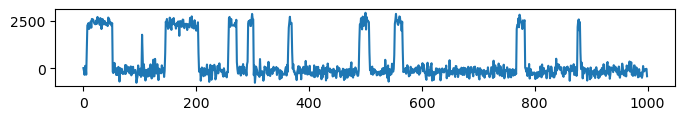

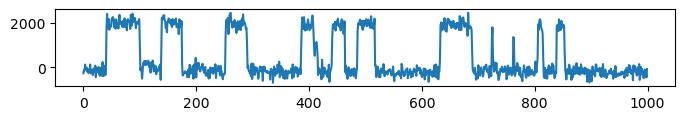

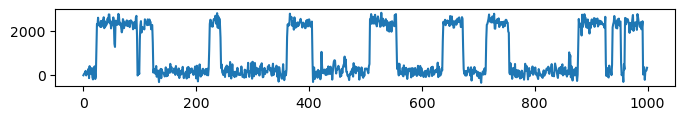

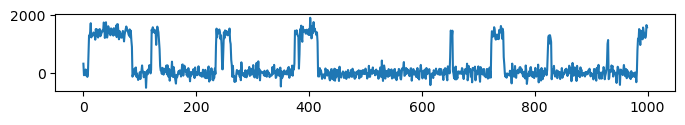

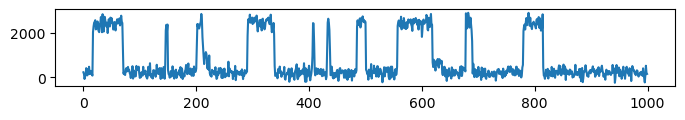

13/13 [==============================] - 2s 138ms/step


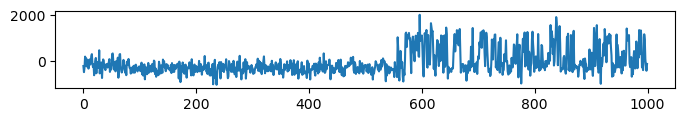

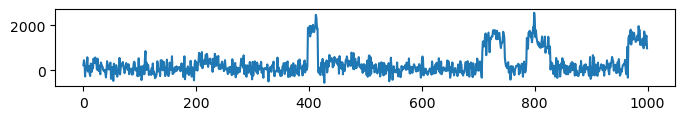

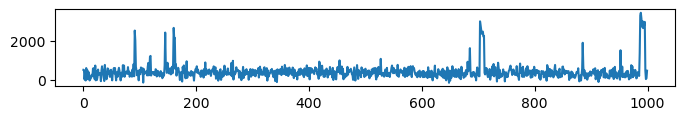

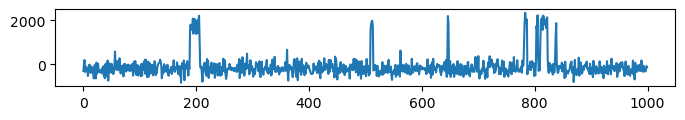

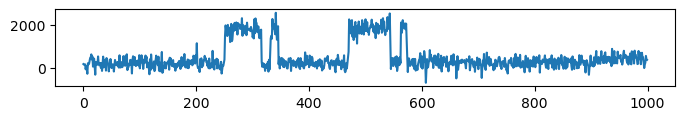

14/14 [==============================] - 3s 198ms/step


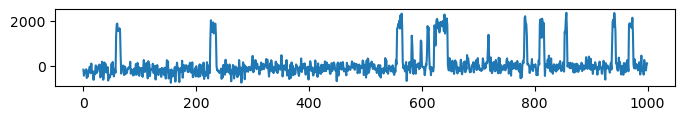

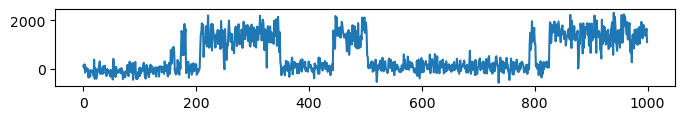

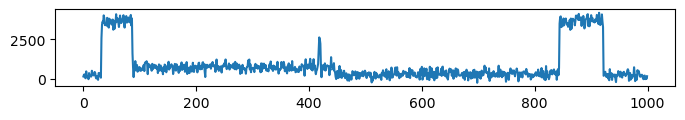

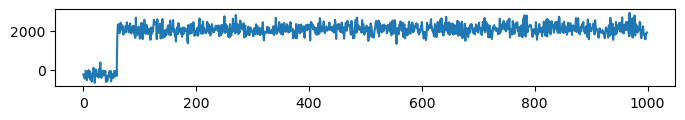

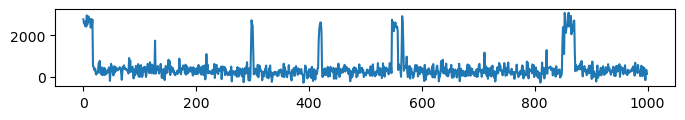

17/17 [==============================] - 2s 139ms/step


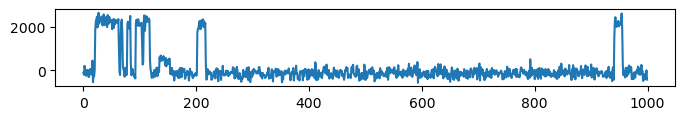

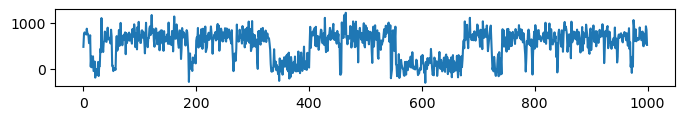

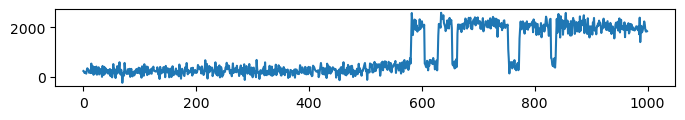

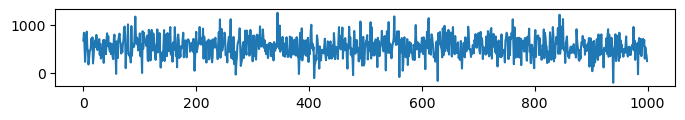

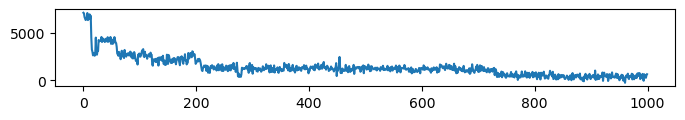

In [13]:
files = '''
../saved_dataset/downstream/simreps/50 fM MUT n1.tif_whole_traces.mat
../saved_dataset/downstream/simreps/50 fM MUT n2.tif_whole_traces.mat
../saved_dataset/downstream/simreps/50 fM MUT n3.tif_whole_traces.mat
../saved_dataset/downstream/simreps/1 to 1 mil n1.tif_whole_traces.mat
../saved_dataset/downstream/simreps/1 to 1 mil n2.tif_whole_traces.mat
../saved_dataset/downstream/simreps/1 to 1 mil n3.tif_whole_traces.mat
../saved_dataset/downstream/simreps/1 to 100k n1.tif_whole_traces.mat
../saved_dataset/downstream/simreps/1 to 100k n2.tif_whole_traces.mat
../saved_dataset/downstream/simreps/1 to 100k n3.tif_whole_traces.mat
../saved_dataset/downstream/simreps/1 to 10k n1.tif_whole_traces.mat
../saved_dataset/downstream/simreps/1 to 10k n2.tif_whole_traces.mat
../saved_dataset/downstream/simreps/1 to 10k n3.tif_whole_traces.mat
../saved_dataset/downstream/simreps/1 to 10k n4.tif_whole_traces.mat
../saved_dataset/downstream/simreps/50 nM WT n5.tif_whole_traces.mat
../saved_dataset/downstream/simreps/50 nM WT n6.tif_whole_traces.mat
../saved_dataset/downstream/simreps/50 nM WT n8.tif_whole_traces.mat
'''.strip().split('\n')

test_sets = []
embedding_list = []
pred_list = []

for file in files:
    test_set = convert_single_channel_data_to_dataset(file, max_frames=1000)
    embedding_list.append(encoder.predict(test_set.to_tensor()))
    pred_list.append(clf.predict_proba(embedding_list[-1])[:, 1] >= WT_cutoff)
    # top score traces
    ranking = np.argsort(clf.predict_proba(embedding_list[-1])[:, 0])
    for i in range(5):
        _, ax = plt.subplots(1, 1, figsize=(8, 1))
        ax.plot(test_set.traces[ranking[i]].acceptor)
    plt.show()

In [16]:
n = 0
for e in embedding_list:
    n += e.shape[0]
print('Number of test traces =', n)

Number of test traces = 5720


ratio between prediction and hmm counting is 1.6521739130434783
ratio between prediction and hmm counting is 1.4129032258064516
ratio between prediction and hmm counting is 1.2921348314606742
ratio between prediction and hmm counting is 1.2894736842105263
ratio between prediction and hmm counting is 0.26666666666666666


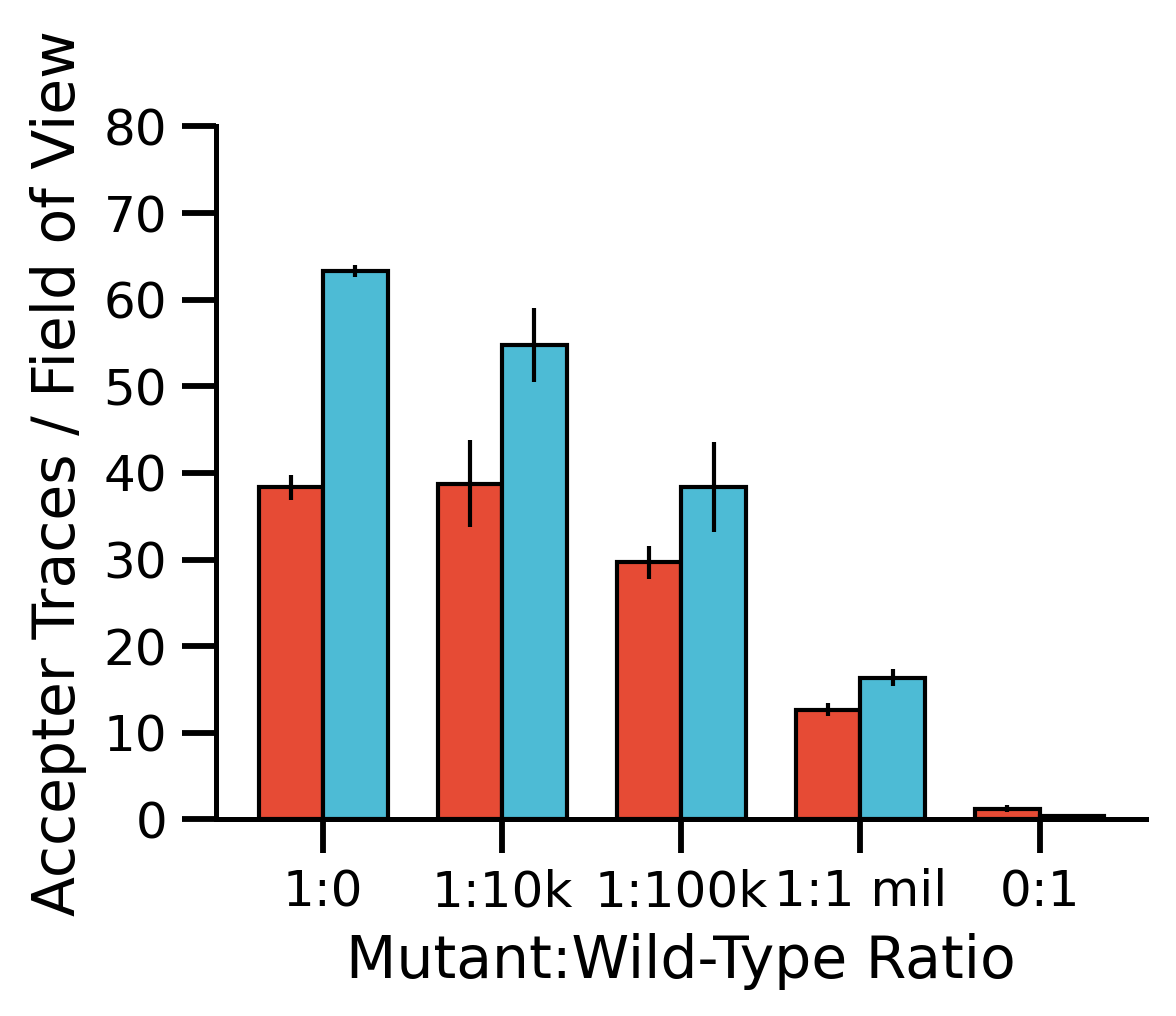

In [18]:
groups = ['MUT', '1 to 10k', '1 to 100k', '1 to 1 mil', 'WT']
names = ['1:0', '1:10k', '1:100k', '1:1 mil', '0:1']

HMM = [[41, 39, 35], [54, 38, 37, 26], [26, 29, 34], [11, 13, 14], [0, 1, 2, 2]]

width = 0.36
with plt.style.context(spstyle.get_style('nature-reviews')):
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig = plt.figure(figsize=(4, 3))
    plt.xlabel('Mutant:Wild-Type Ratio')
    plt.ylabel('Accepter Traces / Field of View')
    plt.bar(np.arange(len(HMM)) - width / 2, [np.mean(x) for x in HMM], width=width, color=color[0], edgecolor='k', linewidth=1)
    plt.errorbar(np.arange(len(HMM)) - width / 2, [np.mean(x) for x in HMM], [np.std(x) / np.sqrt(len(x)) for x in HMM], linewidth=1, color='black', linestyle='none')
        
    for i, group in enumerate(groups):
        counts = []
        n_files = 0
        for j, file in enumerate(files):
            if group in file:
                counts.append(np.sum(pred_list[j]))
                n_files += 1
        count = np.sum(counts) / n_files
        print('ratio between prediction and hmm counting is', count / np.mean(HMM[i]))
        plt.bar([i + width / 2], [count], width=width, color=color[1], edgecolor='k', linewidth=1)
        plt.errorbar([i + width / 2], [count], [np.std(counts) / np.sqrt(n_files)], color='black', linewidth=1)
    plt.xticks(np.arange(len(names)), names)
    plt.ylim([0, 80])
    plt.savefig('figures/fig3-simreps.svg', transparent=True, dpi=200)

../saved_dataset/downstream/simreps/RE12_NDC-1_whole_traces.mat
7/7 [==============================] - 1s 140ms/step


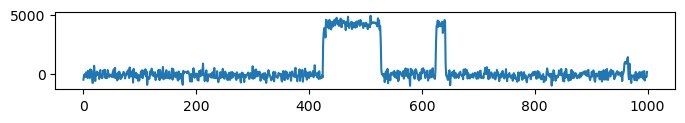

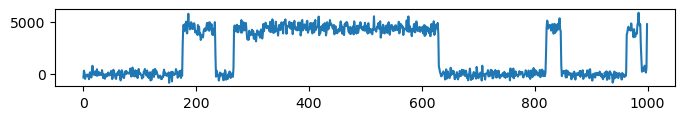

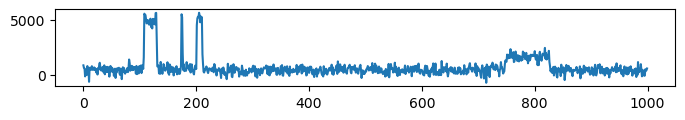

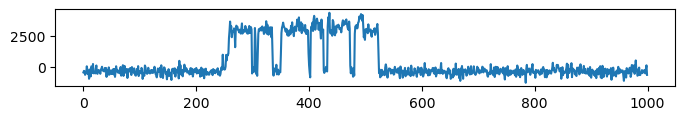

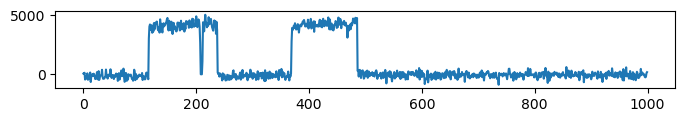

../saved_dataset/downstream/simreps/RE12_NDC-2_whole_traces.mat
8/8 [==============================] - 1s 146ms/step


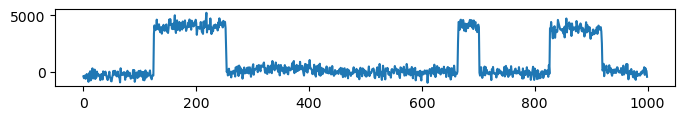

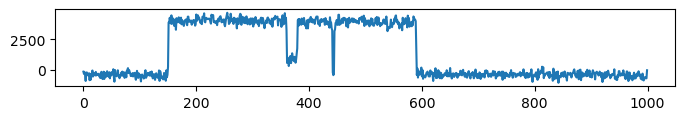

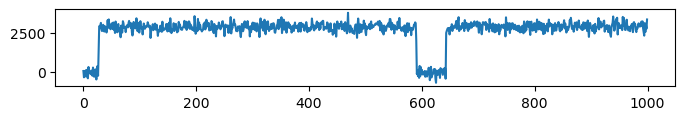

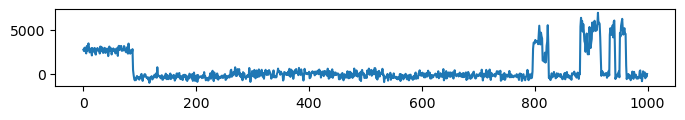

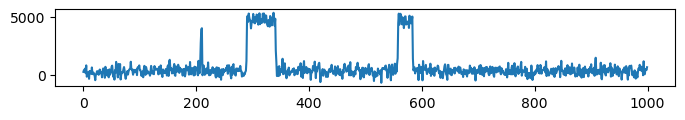

../saved_dataset/downstream/simreps/RE12_NDC-3_whole_traces.mat
8/8 [==============================] - 1s 140ms/step


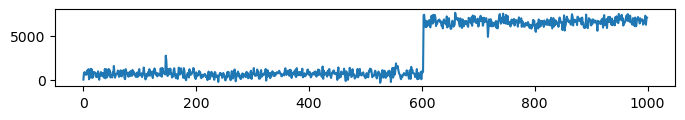

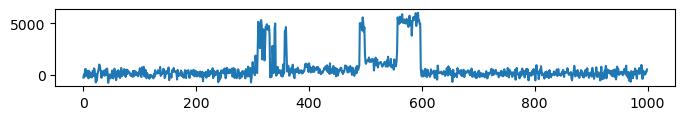

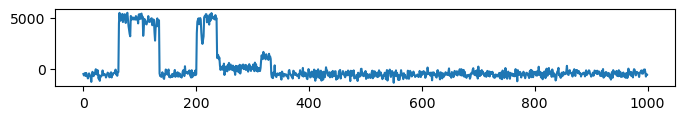

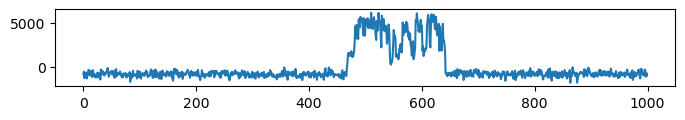

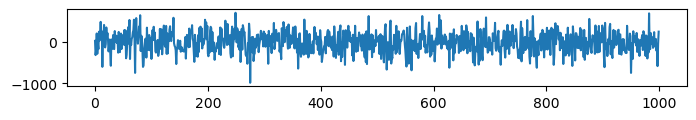

../saved_dataset/downstream/simreps/RE12_1fM-1_whole_traces.mat
9/9 [==============================] - 2s 239ms/step


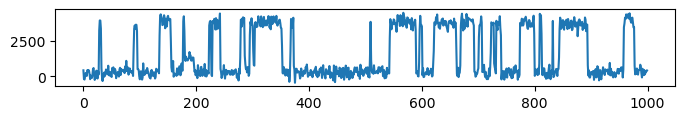

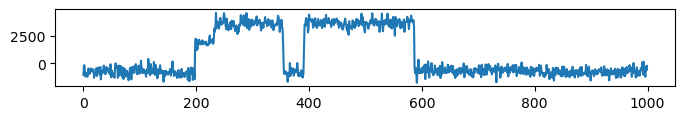

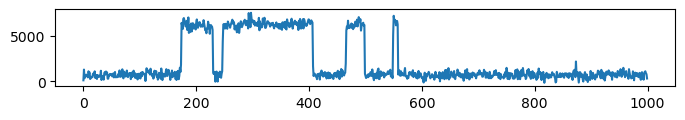

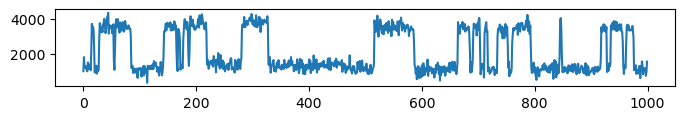

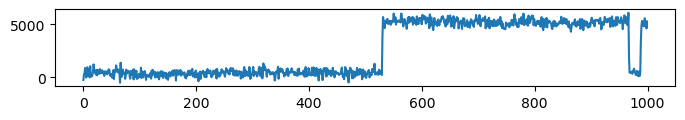

../saved_dataset/downstream/simreps/RE12_1fM-2_whole_traces.mat
9/9 [==============================] - 2s 211ms/step


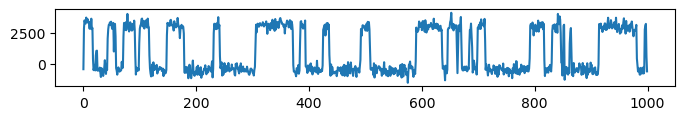

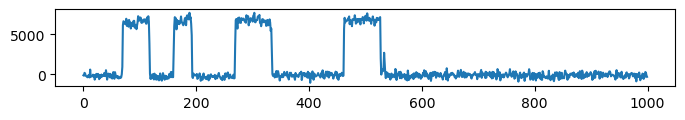

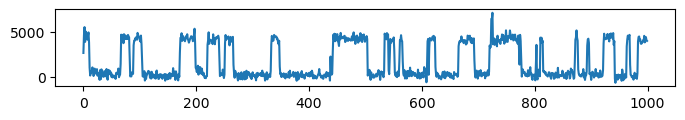

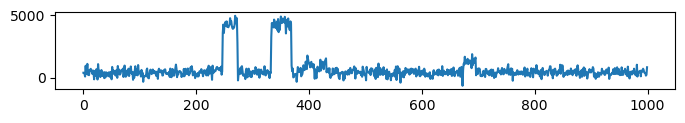

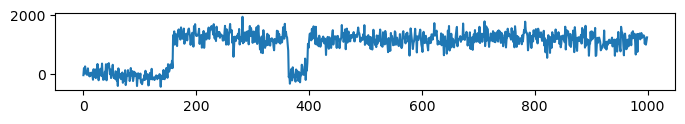

../saved_dataset/downstream/simreps/RE12_1fM-3_whole_traces.mat
8/8 [==============================] - 2s 265ms/step


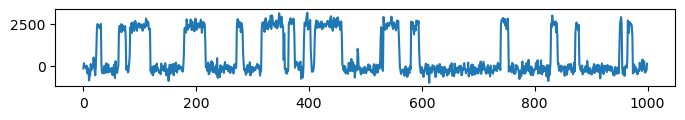

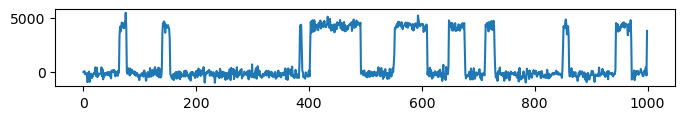

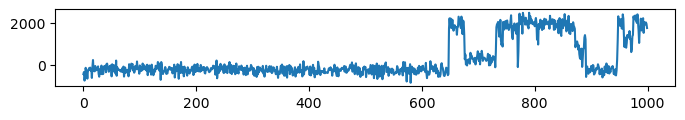

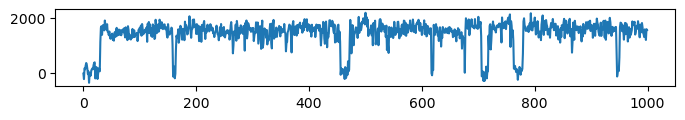

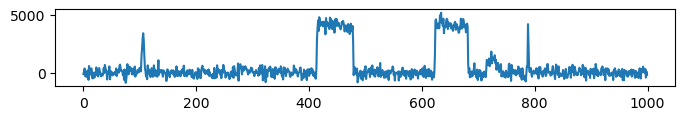

../saved_dataset/downstream/simreps/RE12_5fM-1_whole_traces.mat
9/9 [==============================] - 1s 145ms/step


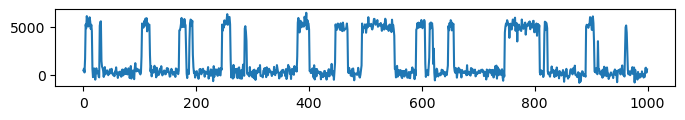

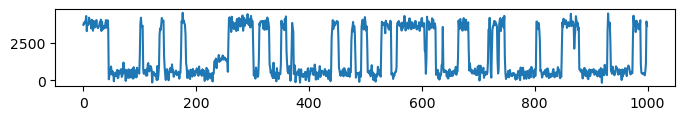

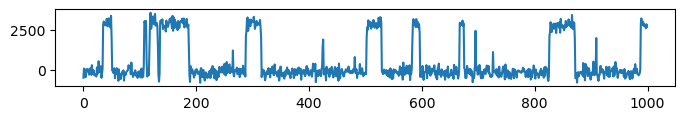

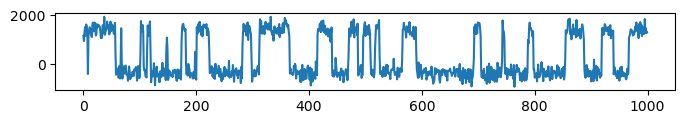

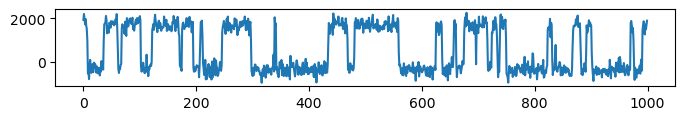

../saved_dataset/downstream/simreps/RE12_5fM-2_whole_traces.mat
10/10 [==============================] - 1s 147ms/step


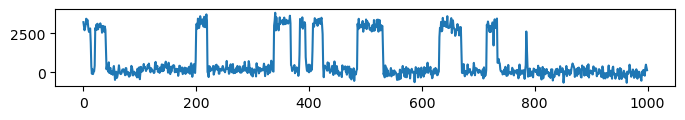

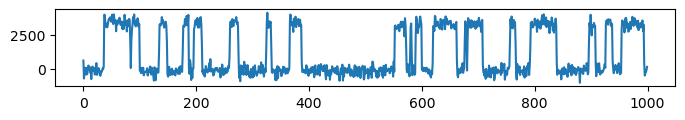

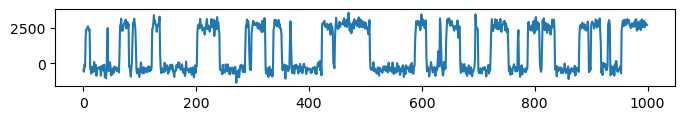

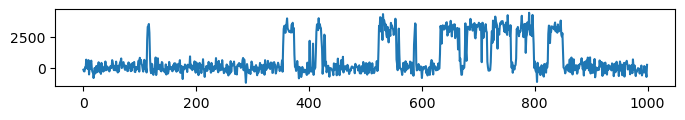

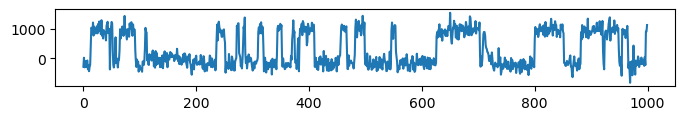

../saved_dataset/downstream/simreps/RE12_5fM-3_whole_traces.mat
9/9 [==============================] - 1s 136ms/step


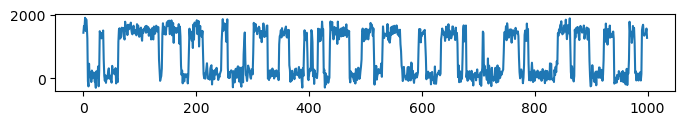

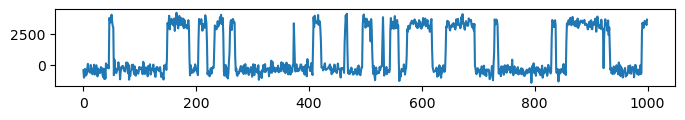

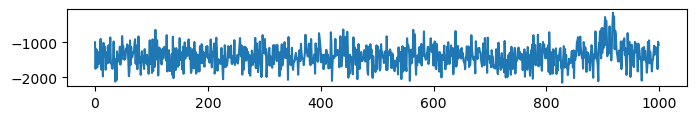

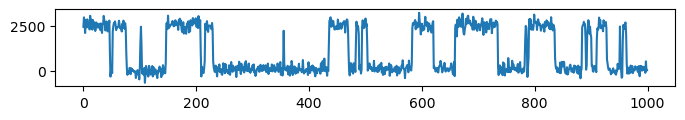

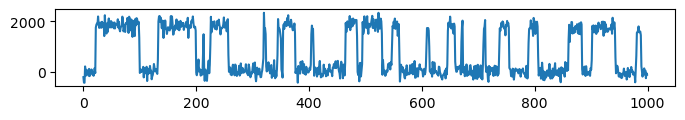

../saved_dataset/downstream/simreps/RE12_10fM-2_whole_traces.mat
17/17 [==============================] - 2s 142ms/step


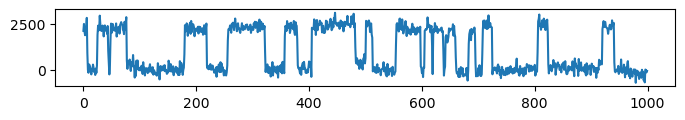

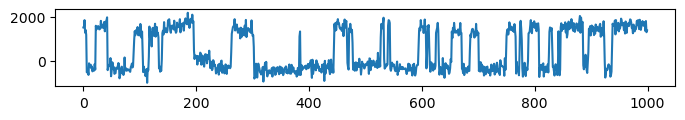

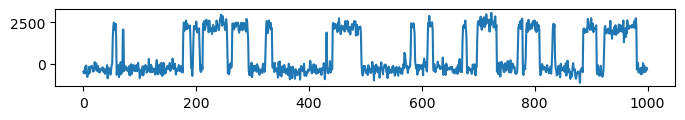

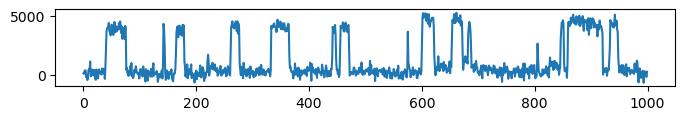

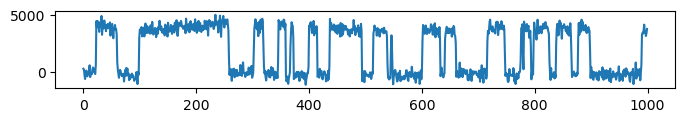

../saved_dataset/downstream/simreps/RE12_50fM-1_whole_traces.mat
8/8 [==============================] - 1s 138ms/step


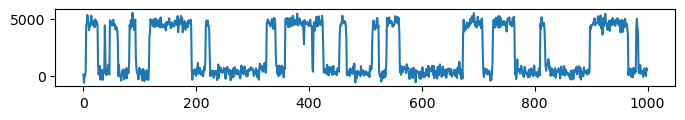

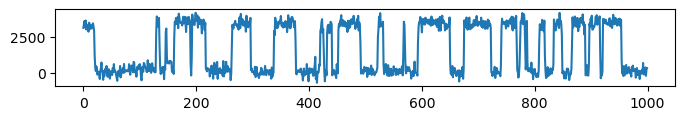

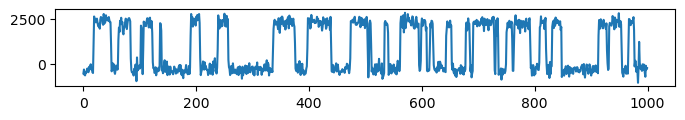

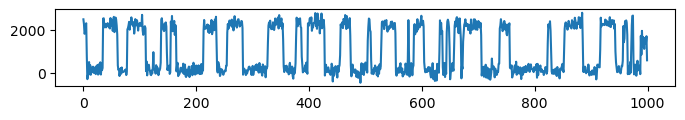

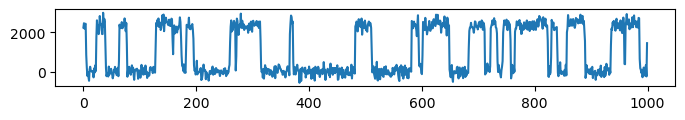

../saved_dataset/downstream/simreps/RE12_50fM-2_whole_traces.mat
9/9 [==============================] - 3s 300ms/step


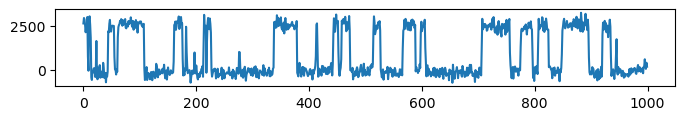

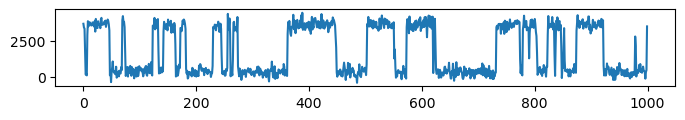

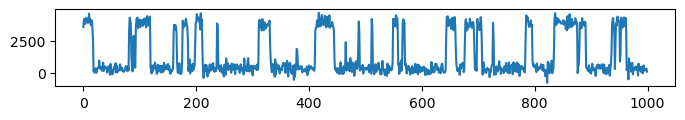

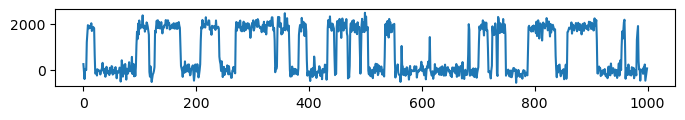

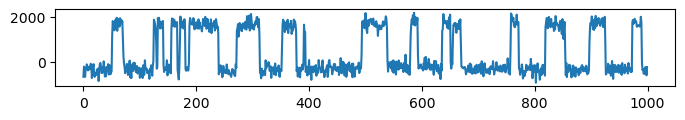

../saved_dataset/downstream/simreps/RE12_50fM-3_whole_traces.mat
5/5 [==============================] - 1s 339ms/step


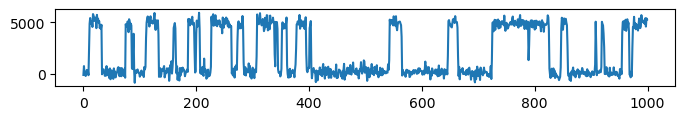

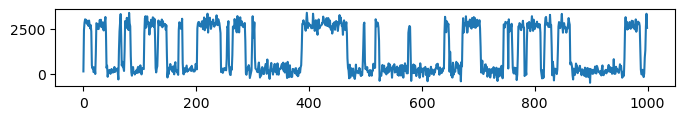

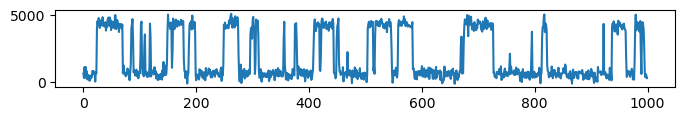

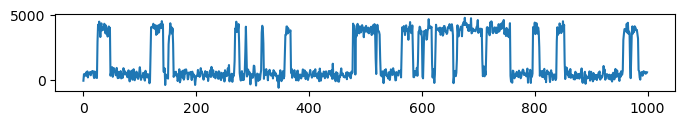

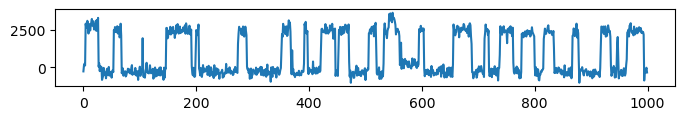

../saved_dataset/downstream/simreps/RE12_250fM-1_whole_traces.mat
20/20 [==============================] - 3s 140ms/step


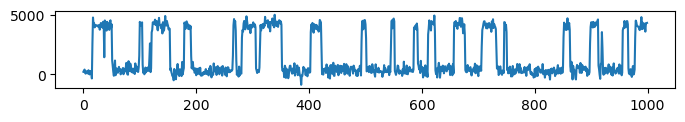

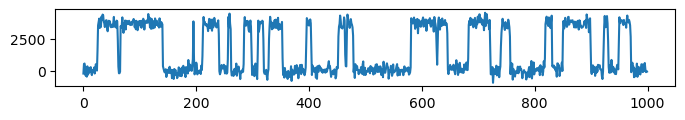

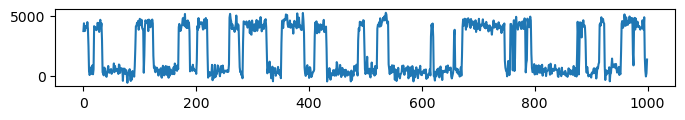

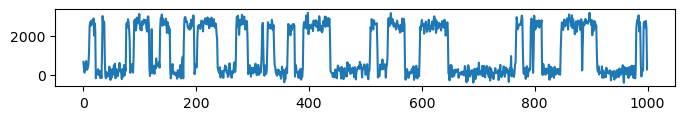

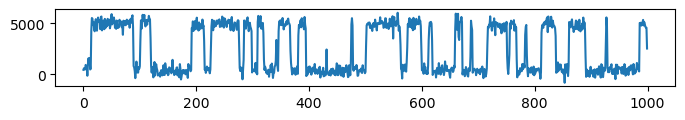

../saved_dataset/downstream/simreps/RE12_250fM-2_whole_traces.mat
20/20 [==============================] - 3s 142ms/step


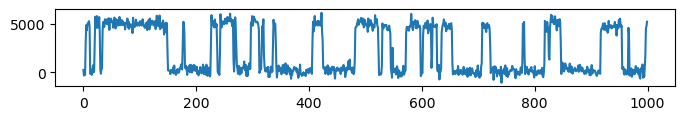

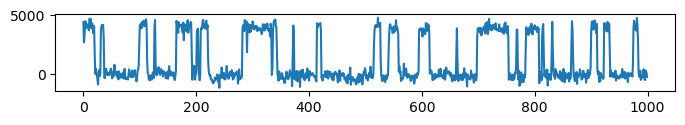

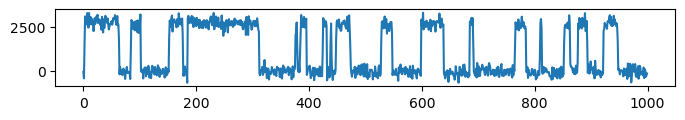

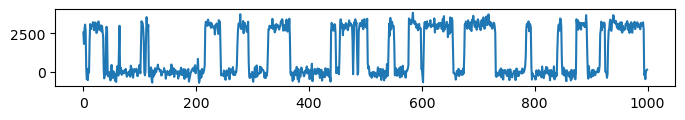

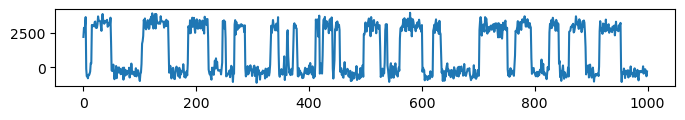

../saved_dataset/downstream/simreps/RE12_250fM-3_whole_traces.mat
18/18 [==============================] - 3s 147ms/step


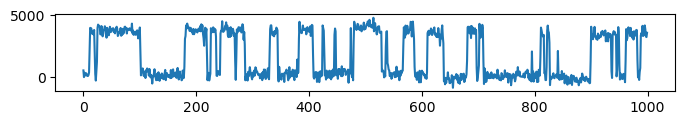

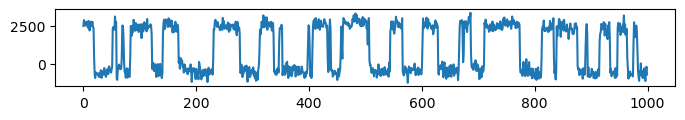

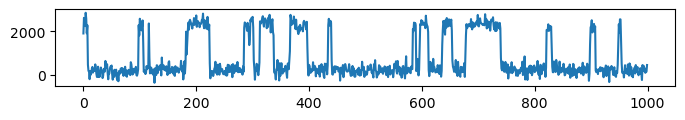

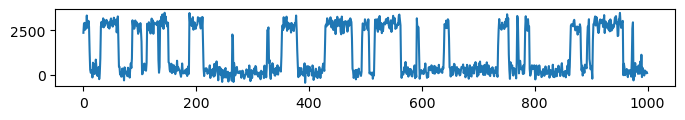

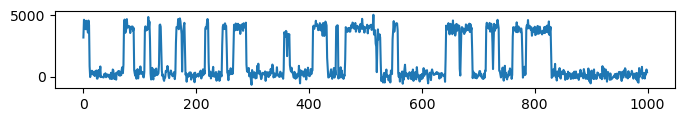

../saved_dataset/downstream/simreps/RE12_500fM-1_whole_traces.mat
30/30 [==============================] - 4s 130ms/step


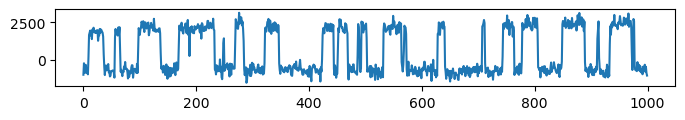

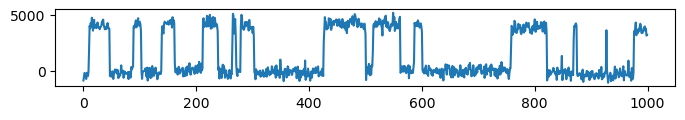

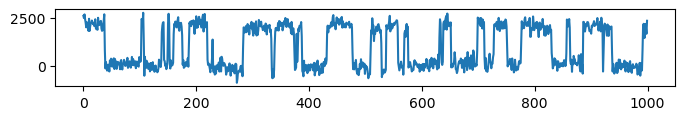

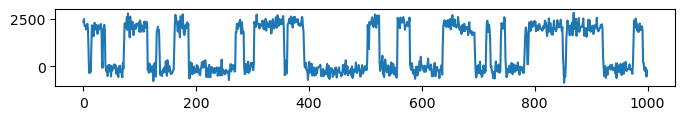

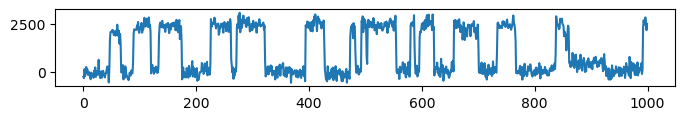

../saved_dataset/downstream/simreps/RE12_500fM-2_whole_traces.mat
32/32 [==============================] - 4s 131ms/step


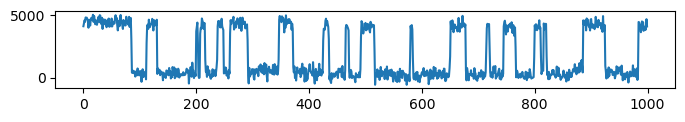

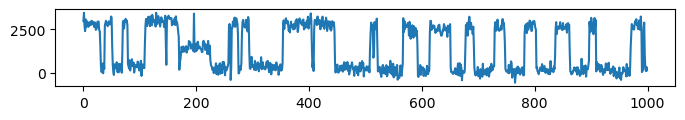

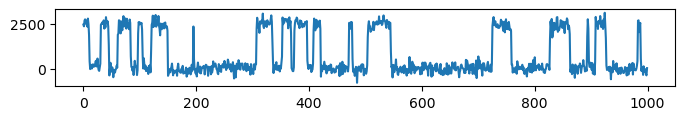

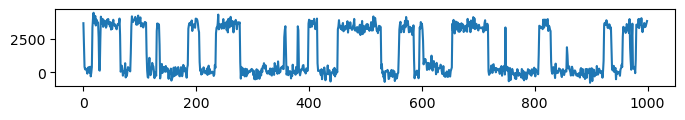

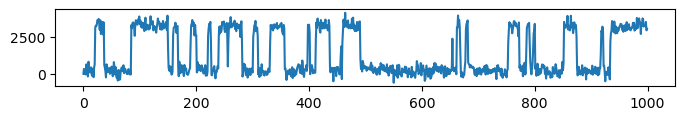

../saved_dataset/downstream/simreps/RE12_500fM-3_whole_traces.mat
32/32 [==============================] - 5s 140ms/step


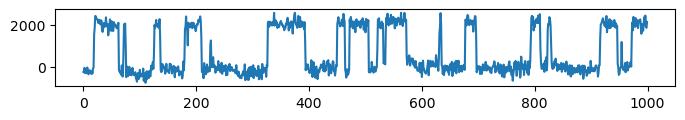

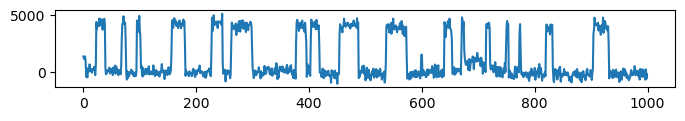

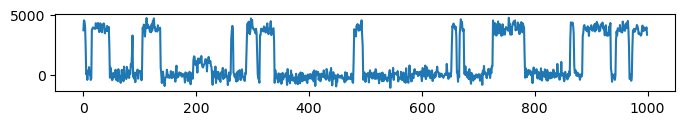

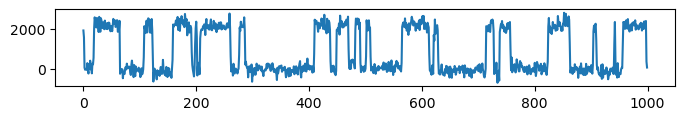

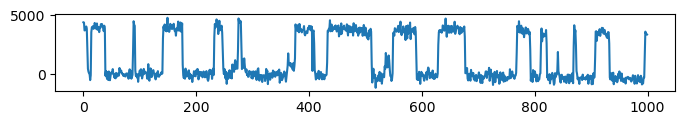

In [19]:
files = '''
../saved_dataset/downstream/simreps/RE12_NDC-1_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_NDC-2_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_NDC-3_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_1fM-1_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_1fM-2_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_1fM-3_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_5fM-1_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_5fM-2_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_5fM-3_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_10fM-2_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_50fM-1_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_50fM-2_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_50fM-3_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_250fM-1_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_250fM-2_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_250fM-3_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_500fM-1_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_500fM-2_whole_traces.mat
../saved_dataset/downstream/simreps/RE12_500fM-3_whole_traces.mat
'''.strip().split('\n')

test_sets = []
embedding_list = []
pred_list = []

for file in files:
    print(file)
    test_set = convert_single_channel_data_to_dataset(file, max_frames=1000)
    embedding_list.append(encoder.predict(test_set.to_tensor()))
    pred_list.append(clf.predict_proba(embedding_list[-1])[:, 1] > WT_cutoff)
    # top score traces
    ranking = np.argsort(clf.predict_proba(embedding_list[-1])[:, 0])
    for i in range(5):
        _, ax = plt.subplots(1, 1, figsize=(8, 1))
        ax.plot(test_set.traces[ranking[i]].acceptor)
    plt.show()

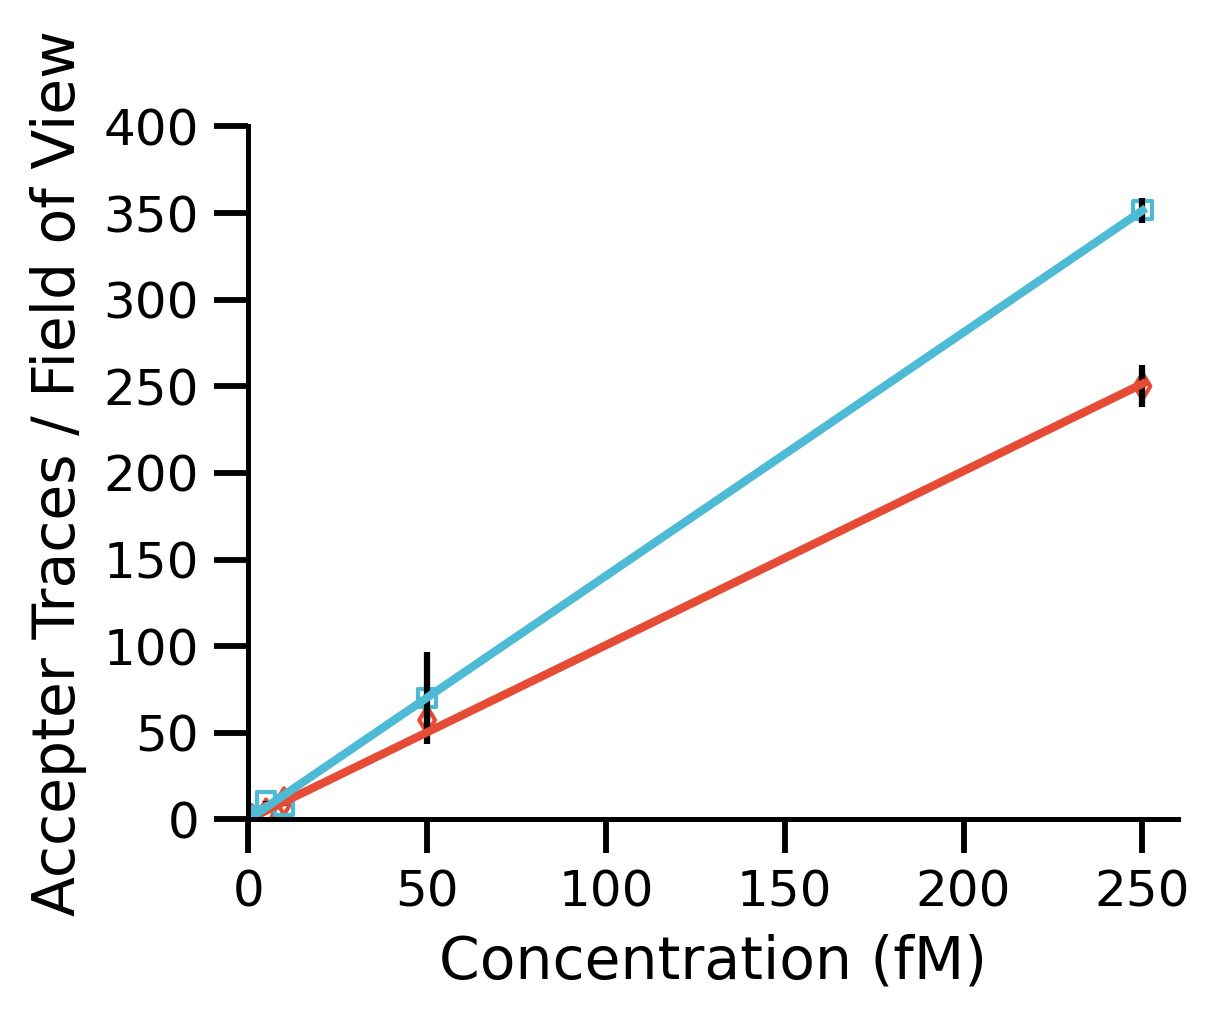

In [21]:
groups = ['_NDC', '_1fM', '_5fM', '_10fM', '_50fM', '_250fM',]
location = [0, 1, 5, 10, 50, 250,]

HMM = [0, 0.67, 3.83, 10.33, 57.33, 250.00]
HMM_err = [0, 0.33, 0.98, 2.33, 2.6, 12.1]
HMM_reg = LinearRegression(fit_intercept=False).fit(np.expand_dims(location, axis=-1), HMM)

width = 0.36
with plt.style.context(spstyle.get_style('nature-reviews')):
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig = plt.figure(figsize=(4, 3))
    plt.xlabel('Concentration (fM)')
    plt.ylabel('Accepter Traces / Field of View')
    plt.scatter(location, HMM, color=color[0], edgecolor=color[0], linewidth=1, s=20, facecolor='none', marker='d')
    plt.plot(location, HMM_reg.predict(np.expand_dims(location, axis=-1)), color=color[0])
    plt.errorbar(location, HMM, HMM_err, color='k', linewidth=1.5, linestyle='none')
    counts = []
    err = []
    for i, group in enumerate(groups):
        counts.append([])
        n_files = 0
        for j, file in enumerate(files):
            if group in file:
                counts[-1].append(np.sum(pred_list[j]))
                n_files += 1
        count = np.sum(counts[-1]) / n_files
        err.append(np.std(counts[-1]) / np.sqrt(n_files))
        counts[-1] = count
    reg = LinearRegression(fit_intercept=False).fit(np.expand_dims(location, axis=-1), counts)
    plt.scatter(location, counts, color=color[1], edgecolor=color[1], linewidth=1, s=20, facecolor='none', marker='s')
    plt.plot(location, reg.predict(np.expand_dims(location, axis=-1)), color=color[1])
    plt.errorbar(location, counts, err, color='k', linewidth=1.5, linestyle='none')
    plt.ylim([0, 400])
    plt.xlim([0, 260])

In [27]:
print('Increases the sensitivity by', np.round(reg.coef_ / HMM_reg.coef_, 2)[0], 'fold')

Increases the sensitivity by 1.4 fold
